In [ ]:
#############################################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
#############################################################################################################
# Investigate relationships between the qualitative evaluation measure (appropriateness) and 5 personality traits. 
#############################################################################################################

In [1]:
###############################################################################################################
# Statistics of personality labels associated with subjects / SIDs
# There are 5 labels for each SID, at continuous scale: 1-10
# Labels obtained from self-assessment
###############################################################################################################

import numpy as np
import matplotlib.pyplot as plt
import glob
import time

#############################################
# Load data

# 5 personality dimensions/traits (Big 5 model); ordered as columns in the labels dataset
personality_dims = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs']
unique_srt_SIDs = np.array([x[:5] for i, x in enumerate(unique_srt_VIDs) if i % 2 == 0]) # ['PID02', 'PID05', ..
# Labels are ordered as unique_srt_SIDs
personality_data = np.loadtxt('./../Dataset/Labels/personality_self_assessments.csv', delimiter=',', skiprows=1, dtype=float, usecols=(0, 1,2,3,4,5))

######################
# Create matrix of continuous labels, removing subject PID19 (not used at all)
cont_labels = [] # continuous labels
for i, SID in enumerate(personality_data[:,0]):
    SID = 'PID{:02.0f}'.format(SID)
    #print SID
    if SID in unique_srt_SIDs:
        cont_labels.append( personality_data[i, 1:] )
cont_labels = np.array( cont_labels )
print cont_labels

############################################################
# Binary labels (low/high) are assigned depending whether the personality trait score is above average
means = np.mean(cont_labels, axis=0)
binary_labels = np.zeros(cont_labels.shape)
for i in range(cont_labels.shape[0]):
    for j in range(cont_labels.shape[1]):
        if cont_labels[i,j] > means[j]:
            binary_labels[i,j] = 1.
print binary_labels
print len(cont_labels), len(binary_labels)


[[  3.5   7.    7.    7.    3. ]
 [  5.5   6.5   7.5   7.5   7. ]
 [  9.    7.    9.    3.5   8. ]
 [  9.5   5.5   8.    3.    5.5]
 [  8.    7.    8.    6.    6.5]
 [  9.    5.5  10.    5.5   9.5]
 [  8.5   7.5   8.    3.5   6.5]
 [  2.5   2.    7.    5.5   8.5]
 [  7.5   6.    6.    2.5   9. ]
 [  5.    3.5   6.    8.5   9. ]
 [  5.    6.5   7.    3.5   3. ]
 [  7.    8.5   8.    2.5   6. ]
 [  8.5   7.    8.    6.    4.5]
 [  5.5   6.5   4.5   5.    7. ]
 [  7.5   8.5   5.    6.    5.5]
 [  7.    6.    8.5   5.    6. ]
 [  9.    7.5   6.    5.    5.5]
 [  8.    4.5   6.    5.5   7.5]
 [  6.5  10.    5.5   3.    5.5]]
[[ 0.  1.  0.  1.  0.]
 [ 0.  1.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.]
 [ 1.  0.  1.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.]
 [ 0.  0.  0.  1.  1.]
 [ 1.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.]
 [ 1.  1.  1.  1.  0.]
 [ 0.  1.  0.  1.  1.]
 [ 1.  1.  0.  1.  0.]
 [ 1.  0.  1.  1.  0.]
 [ 1

Distribution of subjects into personalities
[12, 12, 9, 12, 10]
[7, 7, 10, 7, 9]


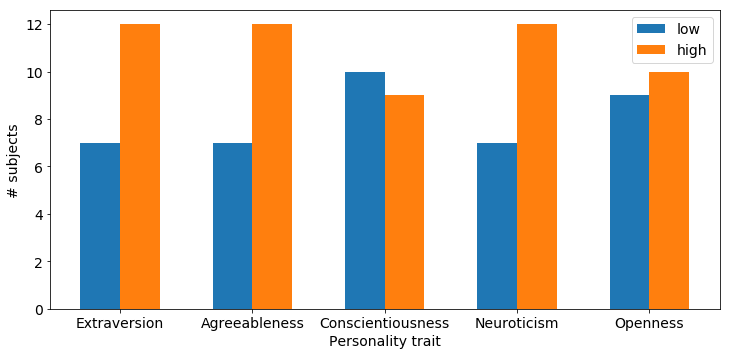

In [2]:
#############################################################
# Continuous stats, not used
# clrs = ['red', 'green', 'yellow', 'blue', 'orange']
# x = np.arange(len(cont_labels))
# w = 0.15 # bar width
# plt.figure(figsize=(20,10))
# for i, p in enumerate(personality_dims):
#     plt.bar(x-w*(2.5-i), cont_labels[:,i], width=w, align='edge', label=p, color=clrs[i])
# plt.xticks(x, x, rotation=0)
# plt.ylabel('Personality trait', fontsize=14)
# plt.xlabel('Subject', fontsize=14)
# plt.legend()
# plt.show()

# for i, p in enumerate(personality_dims):
#     plt.figure(figsize=(20,10))
#     plt.bar(x, cont_labels[:,i], width=w, align='center', label=p, color=clrs[i])
#     plt.xticks(x, x, rotation=0)
#     plt.ylabel('Personality trait', fontsize=14)
#     plt.xlabel('Subject', fontsize=14)
#     plt.legend()
#     plt.show()

#############################################################
# Binary stats
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
print "Distribution of subjects into personalities"
ones  = [np.count_nonzero(binary_labels[:,i]) for i in range(5)]
zeros = [len(binary_labels) - np.count_nonzero(binary_labels[:,i]) for i in range(5)]
print ones
print zeros

x = np.arange(len(personality_dims))
w = 0.3 # bar width
# plt.figure(figsize=(12,8))
plt.figure(figsize=(12,5.5))
# plt.figure()
plt.bar(x-w/2, zeros, width=w, label='low')
plt.bar(x, ones, width=w, label='high', align='edge')
plt.xticks(x, personality_dims, rotation=0)
plt.xlabel('Personality trait')#, fontsize=14)
plt.ylabel('# subjects')#, fontsize=14)
plt.legend()
# plt.ylim(3,8)
plt.show()

In [3]:
##################################################################################
# Load eval metric APPROPRIATENESS from natural speech based survey for all 4 models
##################################################################################

import numpy as np
import time
import glob
import matplotlib.pyplot as plt
from tabulate import tabulate
from evalutils import plot_4RMSE, calculate_norm_delta_jerk_onList

model_types = [
    'MLP_SI',
    'LSTM_SI',
    'MLP_SD',
    'LSTM_SD'
]

TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs']
unique_srt_SIDs = np.array([x[:5] for i, x in enumerate(unique_srt_VIDs) if i % 2 == 0]) # ['PID02', 'PID05', ..

# DATA: stores mean appropriateness value, for each original subject (out of 19) and for each model
DATA = {} 
dd = np.load('./../Dataset/Survey/responses_num.npz')

for m in [ 'MLP_SI', 'LSTM_SI']:
    DATA[m] = np.zeros( (len(unique_srt_SIDs)) ) # approp. measure
    for s, SID in enumerate(unique_srt_SIDs):
        ind1 = np.argwhere(dd['gt_SI'] == SID + 'Task2')[0,0] # column in responses where this VID occurs
        ind2 = np.argwhere(dd['gt_SI'] == SID + 'Task3')[0,0] # column in responses where this VID occurs
        DATA[m][s] = np.mean( dd[m][:, [ind1, ind2]] ) # all responses for this SID
        
for m in [ 'MLP_SD', 'LSTM_SD']:
    DATA[m] = np.zeros( (len(unique_srt_SIDs)) ) # approp. measure
    for s, SID in enumerate(unique_srt_SIDs):
        ind1 = np.argwhere(dd['gt_SD'] == SID + 'Task2')[0,0] # column in responses where this VID occurs
        ind2 = np.argwhere(dd['gt_SD'] == SID + 'Task3')[0,0] # column in responses where this VID occurs
        DATA[m][s] = np.mean( dd[m][:, [ind1, ind2]] ) # all responses for this SID

MODEL:  MLP_SI
Extraversion x Aappropriateness  -------  MLP_SI
err
Agreeableness x Aappropriateness  -------  MLP_SI
err
Conscientiousness x Aappropriateness  -------  MLP_SI
	-0.208792495195 0.837132818271
	 samples A and B are NOT significantly different
False
Neuroticism x Aappropriateness  -------  MLP_SI
err
Openness x Aappropriateness  -------  MLP_SI
	-1.43916284212 0.17074797388
	 samples A and B are NOT significantly different
False
	-0.821177939132 0.413996677383
	 samples A and B are NOT significantly different


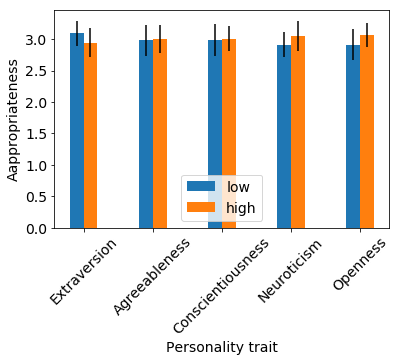

-------------------------------------------------------------------------------------------------
MODEL:  LSTM_SI
Extraversion x Aappropriateness  -------  LSTM_SI
err
Agreeableness x Aappropriateness  -------  LSTM_SI
err
Conscientiousness x Aappropriateness  -------  LSTM_SI
	-0.422331760699 0.678316868721
	 samples A and B are NOT significantly different
False
Neuroticism x Aappropriateness  -------  LSTM_SI
err
Openness x Aappropriateness  -------  LSTM_SI
	0.553101594216 0.588535082264
	 samples A and B are NOT significantly different
False
	-0.354251361827 0.724027137091
	 samples A and B are NOT significantly different


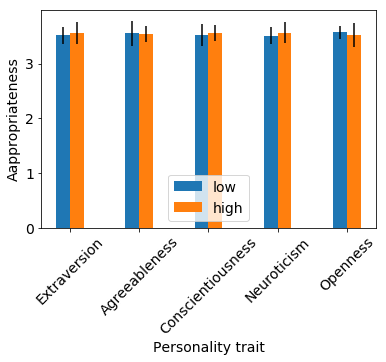

-------------------------------------------------------------------------------------------------
MODEL:  MLP_SD
Extraversion x Aappropriateness  -------  MLP_SD
err
Agreeableness x Aappropriateness  -------  MLP_SD
err
Conscientiousness x Aappropriateness  -------  MLP_SD
	-2.30364511447 0.0356523907464
	 samples A and B are significantly different
True
Neuroticism x Aappropriateness  -------  MLP_SD
err
Openness x Aappropriateness  -------  MLP_SD
	0.893113542047 0.3843976357
	 samples A and B are NOT significantly different
False
	-1.45053734637 0.150547841524
	 samples A and B are NOT significantly different


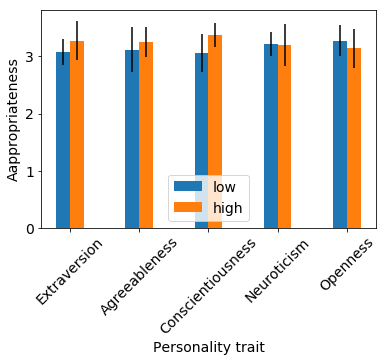

-------------------------------------------------------------------------------------------------
MODEL:  LSTM_SD
Extraversion x Aappropriateness  -------  LSTM_SD
err
Agreeableness x Aappropriateness  -------  LSTM_SD
err
Conscientiousness x Aappropriateness  -------  LSTM_SD
	-1.39786998183 0.180222962108
	 samples A and B are NOT significantly different
False
Neuroticism x Aappropriateness  -------  LSTM_SD
err
Openness x Aappropriateness  -------  LSTM_SD
	0.707474763764 0.489209325064
	 samples A and B are NOT significantly different
False
	0.0931818181818 0.983345599374
	 samples A and B are NOT significantly different


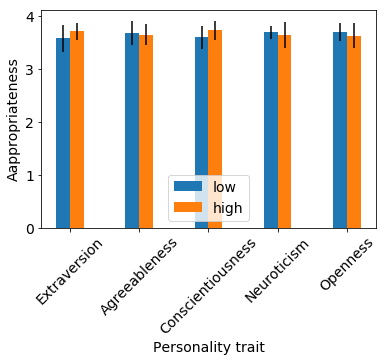

-------------------------------------------------------------------------------------------------


In [5]:
##################################################################################################################
# Examine significance of differences (in appropriateness) between low and high perosonality trait categories
##################################################################################################################

from evalutils import statistical_significance

pval = 0.05

for m in model_types:

    print "MODEL: ", m
    measure = 'Aappropriateness'
    plt.figure()
    w = 0.2 # bar width
    xaxis = np.arange(len(personality_dims))
    means_low = []
    means_high = []
    stds_low = []
    stds_high = []
    LOW = []
    HIGH = []
    for i, personality_dim in enumerate(personality_dims):
        print personality_dim, "x", measure, " ------- ", m
        low_bin = []
        high_bin = []
        for bin_lab, x in zip(binary_labels[:,i],DATA[m][:]):     # for this personality trait go over subjects
            if bin_lab == 0.:
                low_bin.append( float(x) )
                LOW.append(float(x))
            elif bin_lab == 1.:
                high_bin.append( float(x) )
                HIGH.append(float(x))
            else:
                raise ValueError('Incorrect binary label encountered!')
        means_low.append( np.mean(low_bin) )
        means_high.append( np.mean(high_bin) )
        stds_low.append( np.std(low_bin) )
        stds_high.append( np.std(high_bin) )
        try:
            ss = statistical_significance(low_bin, high_bin, pval, False)
            print ss
        except ValueError:
            print "err"

    statistical_significance(LOW, HIGH, pval, False)

    plt.bar(xaxis-w/2., means_low, yerr=stds_low, width=w, align='center', label='low')    # LOW
    plt.bar(xaxis, means_high, yerr=stds_high, width=w, align='edge', label='high') # HIGH
    plt.ylabel(measure) #, fontsize=14)
    plt.xlabel('Personality trait')
    plt.xticks(xaxis, personality_dims, rotation=45)
    # plt.ylim(0, 28)
    plt.legend()
    plt.show()
    print "-------------------------------------------------------------------------------------------------"
